## Questions

- Is the energy and the power of the signal the same?! It's not because of the 1 / N constant
- why is the power interpreted as the variance of the signal?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils as ut

## 2.1 Segmentation

In [32]:
female = AudioSignal(os.path.join(os.getcwd(), '../Exercise4', 'AudioFiles', 'female8khz.wav'))
female.play()

/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise4/AudioFiles/female8khz.wav
Successfully loaded audio signal with 1 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise4/AudioFiles/female8khz.wav


In [33]:
frame_centers_ms, frames = female.get_frames(frame_length_ms=32, frame_shift_ms=8)

## 2.2 Signal power

In [34]:
power = ut.compute_power_in_time_domain(frames)

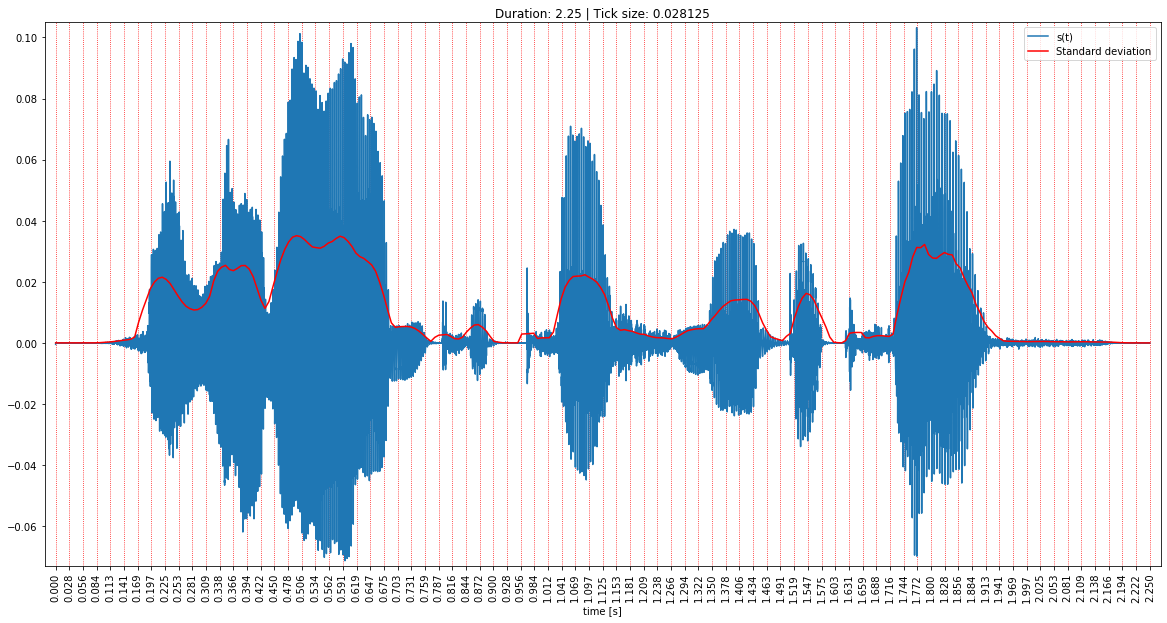

In [35]:
fig, axs = female.plot(return_plot=True)
t = np.linspace(0, female.duration_s, len(power))
axs.plot(t, np.sqrt(power), 'r', label='Standard deviation')
axs.legend()

## 2.3 Voiced / unvoiced decision

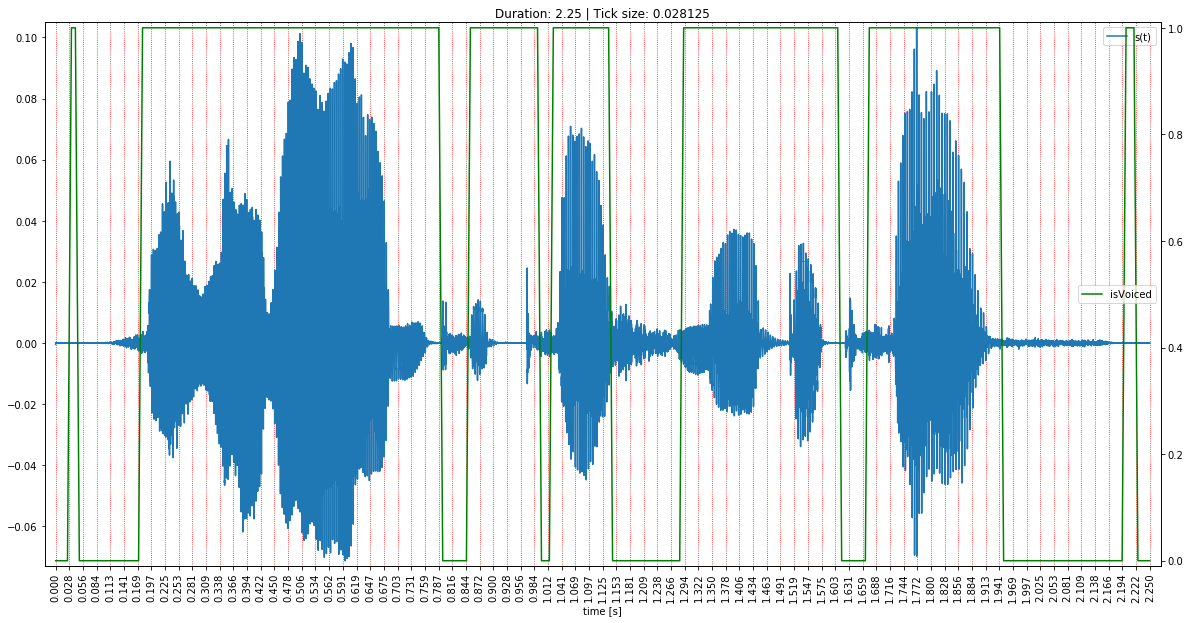

In [37]:
fig, axs = female.plot(return_plot=True)

is_voiced = ut.is_voiced(frames, threshold=.295)
t = np.linspace(0, female.duration_s, len(is_voiced))

axs2 = axs.twinx()
axs2.margins(x=0.01, y=0.01)
axs2.plot(t, is_voiced, 'g', label='isVoiced')
axs2.legend()

## 2.4 Fundamental frequency estimation

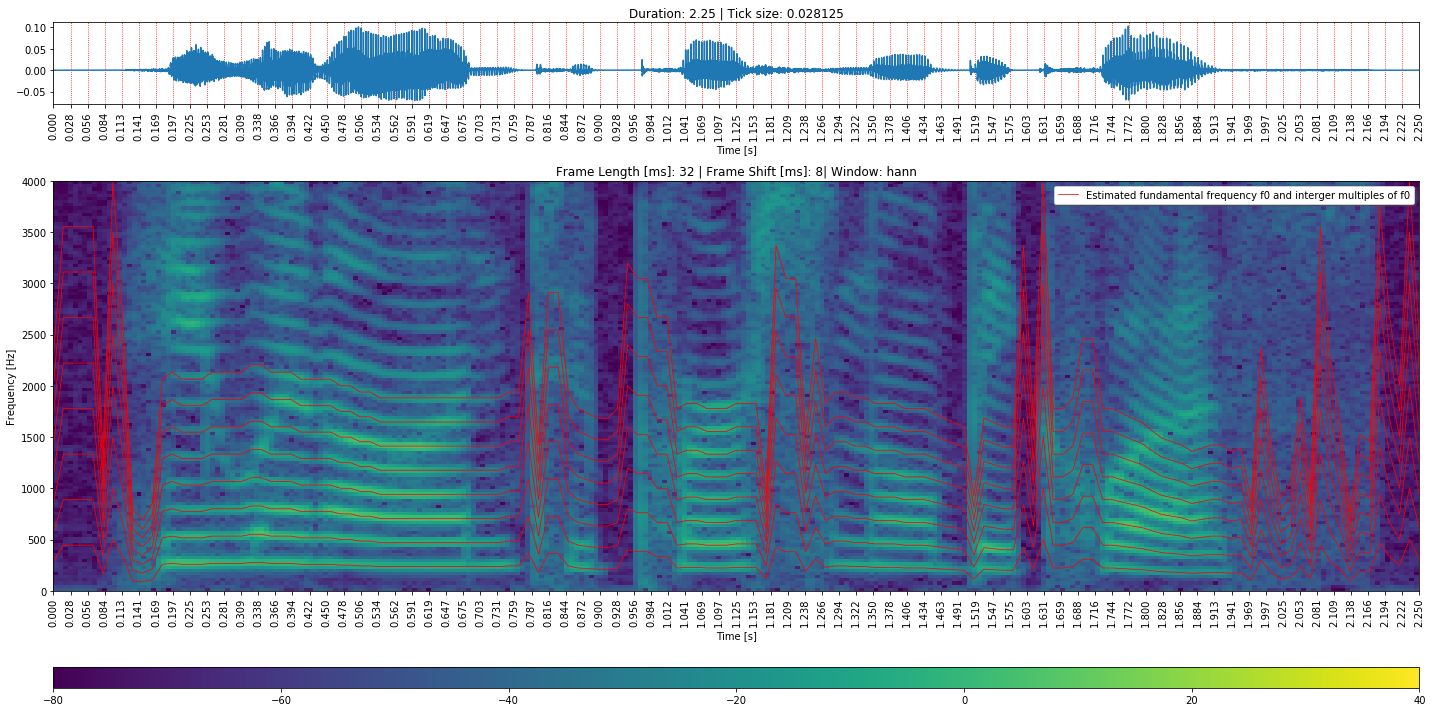

In [38]:
frame_length_ms=32
frame_shift_ms=8
stft, freq_axis, frame_centers_ms = female.compute_stft(frame_length_ms, frame_shift_ms)
fig, axs = female.plot_stft(stft, freq_axis, frame_centers_ms, frame_length_ms, frame_shift_ms, return_plot=True, vmin=-80, vmax=40)


f0 = female.estimate_fundamental_freq()
t = np.linspace(0, female.duration_s, len(f0))
eff_plot = axs[1].plot(t, f0, color='r', linewidth=.75)
axs[1].legend((eff_plot), (['Estimated fundamental frequency f0 and interger multiples of f0']) , loc='upper right', shadow=True)
for i in range(2, 9):
    axs[1].plot(t, f0 * i, color='r', linewidth=.75)
    
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'f0'))

## 2.5 Linear prediction coefficients / linear predictive coding

In [39]:
lpcs = ut.compute_lpc(frames, m=10)

NameError: name 'utils' is not defined

## 3.1 LPCs and constant excitation signal

In [44]:
ex_voiced = ut.create_excitation_signal(female.duration_s * 1000, f0_hz=100, fs_hz=8000, voiced=True)
ex_unvoiced = ut.create_excitation_signal(female.duration_s * 1000, voiced=False)
assert len(ex_voiced.data) == len(ex_unvoiced.data)

Successfully loaded audio signal with 1 channel!
Successfully loaded audio signal with 1 channel!


278 278 278
Successfully loaded audio signal with 1 channel!


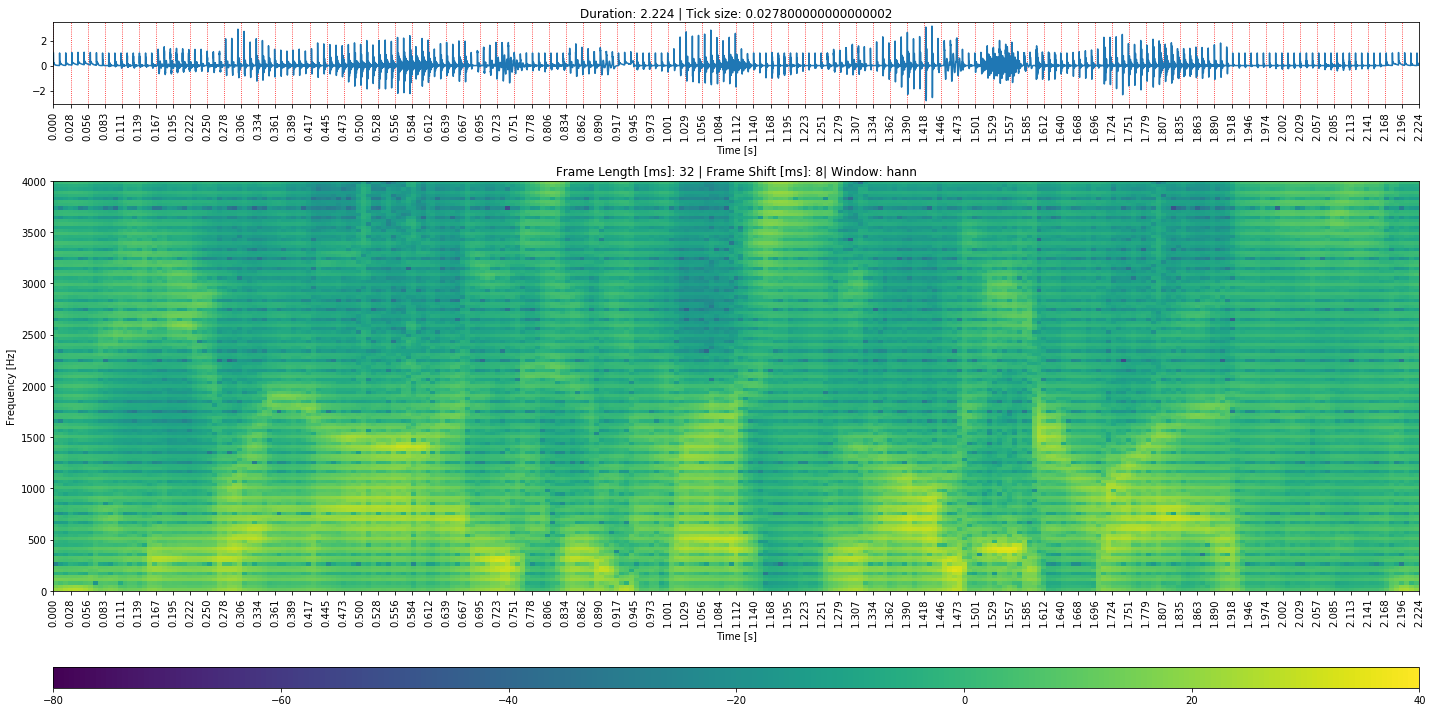

In [46]:
frame_centers_ms, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]
print(len(lpcs), len(ex_voiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_voiced_frames, lpcs):
    signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'voiced_stft'))

278 278 278
Successfully loaded audio signal with 1 channel!


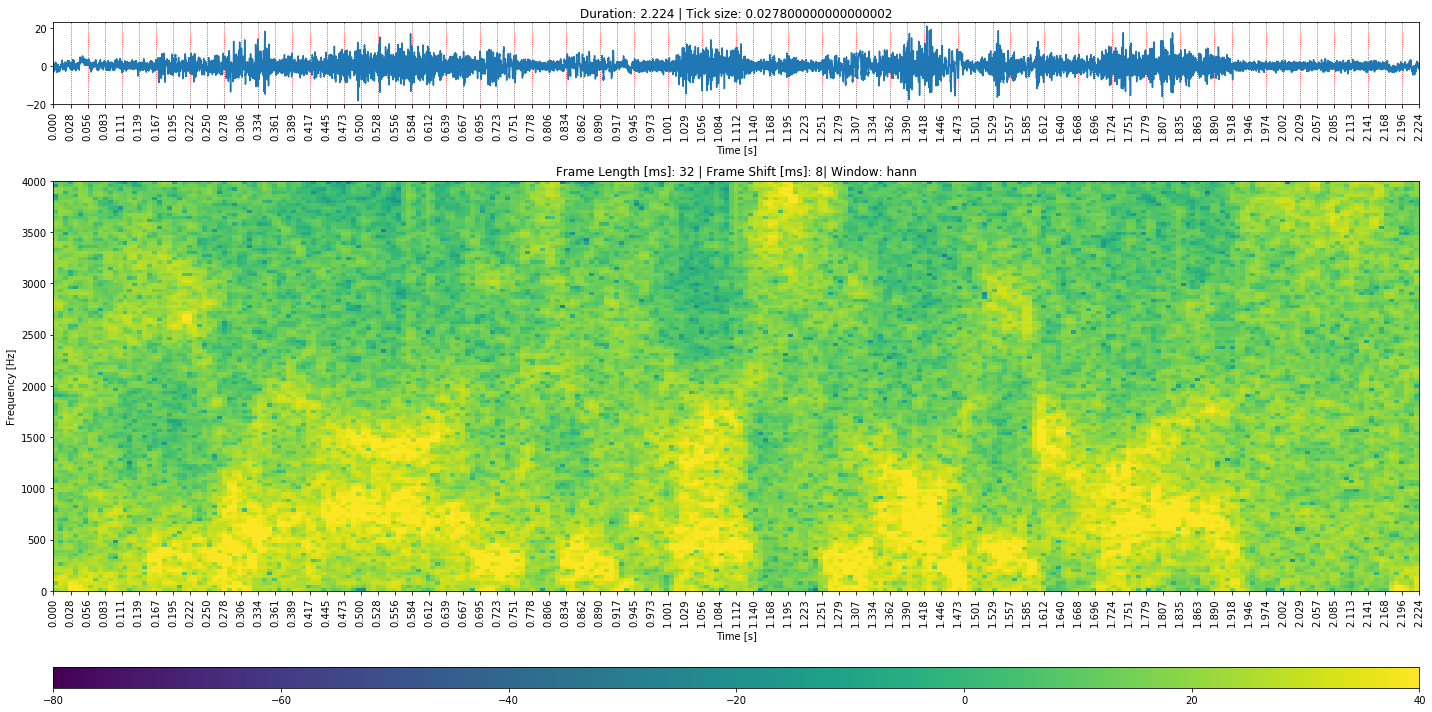

In [49]:
frame_centers_ms, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
print(len(lpcs), len(ex_unvoiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_unvoiced_frames, lpcs):
    signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'unvoiced_stft'))

## 3.2 Voiced/unvoiced excitation

Successfully loaded audio signal with 1 channel!


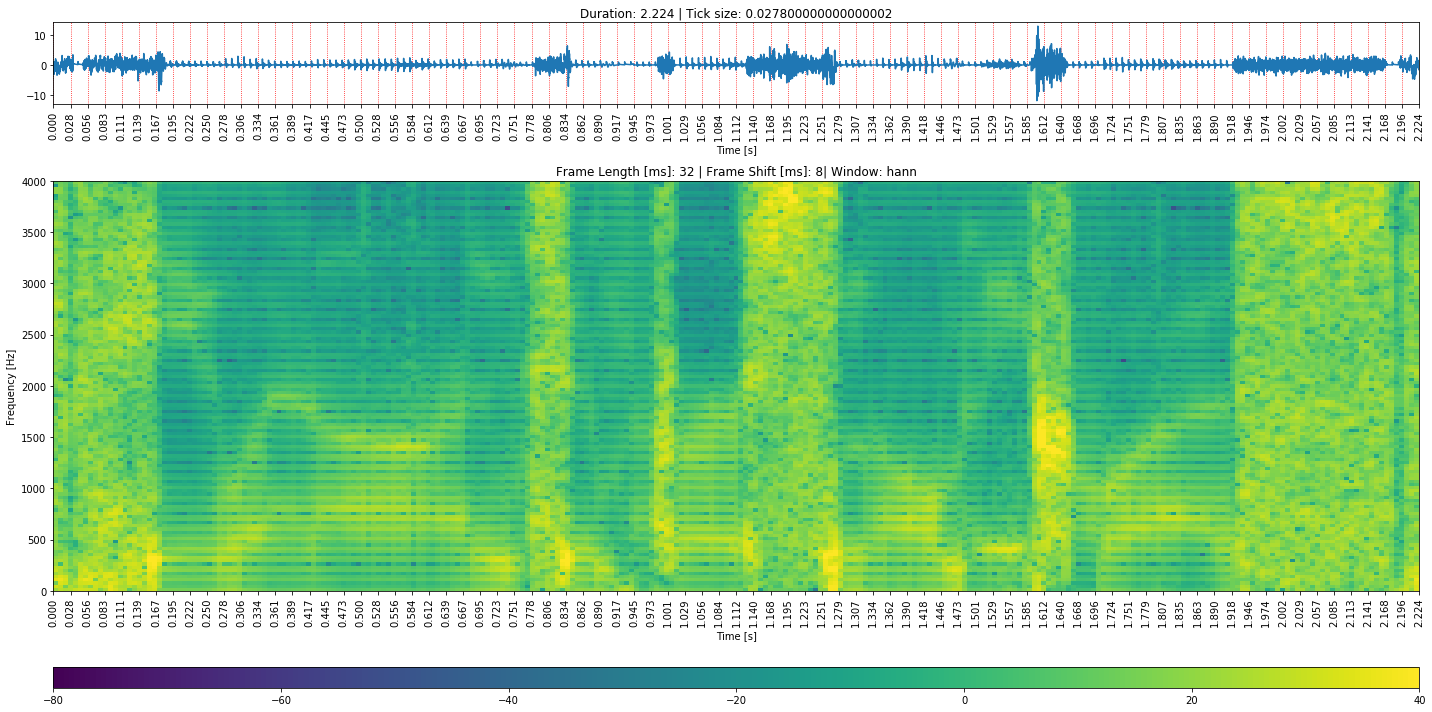

In [50]:
filter_state_out = None
output = np.array([])

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

for voiced_frame, unvoiced_frame, lpc, voiced in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced):
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
    signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'mix_voiced_stft'))

## 3.3 Amplitude modulation

Successfully loaded audio signal with 1 channel!


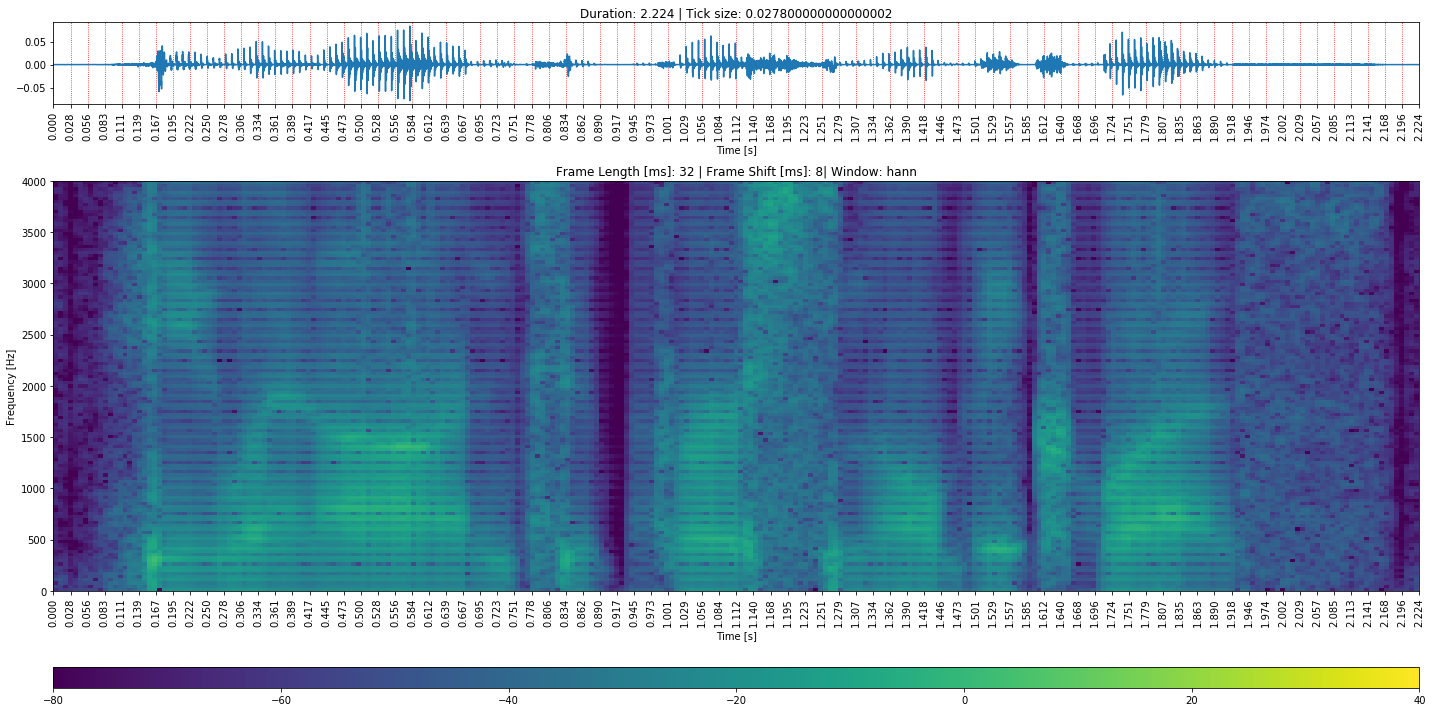

In [51]:
filter_state_out = None
output = np.array([])
_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
for voiced_frame, unvoiced_frame, lpc, voiced, p in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power):
    # voiced unvoiced decision
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
        
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'mix_voiced_stft_with_gain'))

## 3.4 Variable f0

In [52]:
def synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq, fs=8000, concat=True):
    filter_state_out = None
    output = np.array([])
    # Create a counter ... 
    f0_cnt = 0
    
    
    for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
        # voiced unvoiced decision
        frame = unvoiced_frame
        if voiced == 1:
            frame = voiced_frame
            # variable f0
            for i in range(len(voiced_frame)):
                # ... that you increase for every sample of a voiced segment.
                f0_cnt += 1
                # Test if the counter is larger than the current fundamental period in samples.
                if f0_cnt > ut.hz_to_idx(f0, female.sampling_freq):
                    # Every time this is the case, set the counter to zero ...
                    f0_cnt = 0
                    # ... and insert a pulse into the excitation signal at the
                    # corresponding sample of the segment.
                    frame[i] = 1
        
        coeff = lpc
        if concat:
            coeff = np.concatenate(([1], lpc))
        # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
        signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), coeff, frame, filter_state_out)

        # account for amplitude mod / gain
        signal_out = np.sqrt(p) * signal_out

        output = np.append(output, signal_out)

    return AudioSignal(data=output, sampling_freq_hz=fs)

Successfully loaded audio signal with 1 channel!


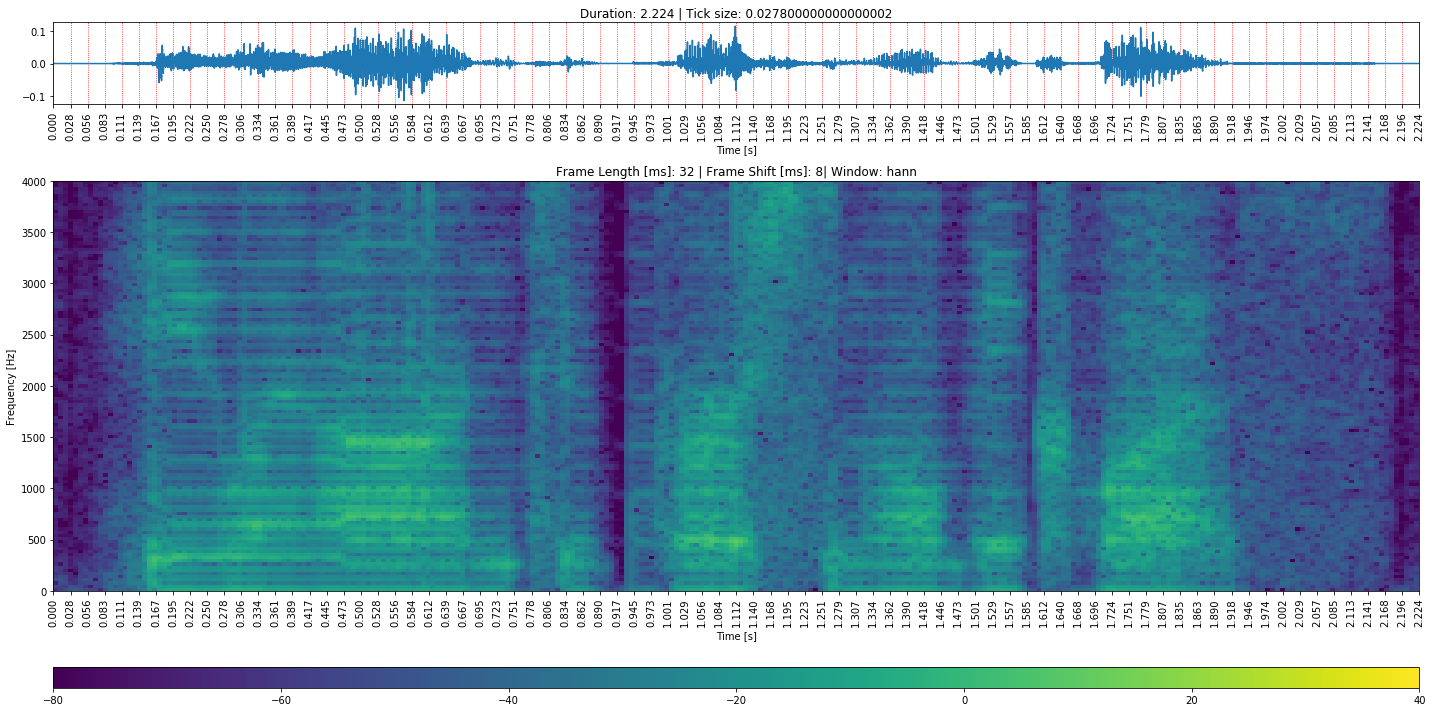

In [53]:

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)
output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq)
output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'mix_voiced_stft_with_gain_and_f0'))

## 3.5 No LPC

Successfully loaded audio signal with 1 channel!


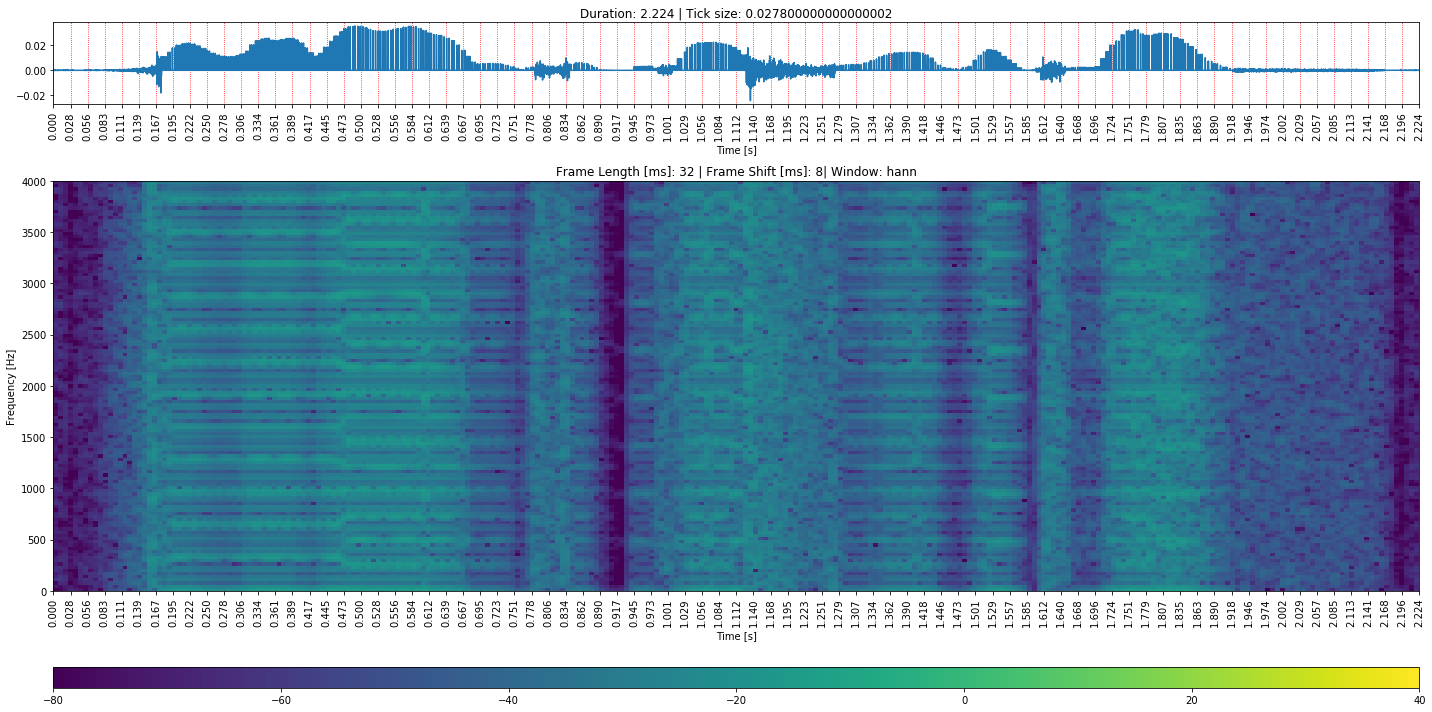

In [55]:
_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)

fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

filter_state_out = None
output = np.array([])
# Create a counter ... 
f0_cnt = 0


for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
    # voiced unvoiced decision
    frame = unvoiced_frame
    if voiced == 1:
        frame = voiced_frame
        # variable f0
        for i in range(len(voiced_frame)):
            # ... that you increase for every sample of a voiced segment.
            f0_cnt += 1
            # Test if the counter is larger than the current fundamental period in samples.
            if f0_cnt > ut.hz_to_idx(f0, female.sampling_freq):
                # Every time this is the case, set the counter to zero ...
                f0_cnt = 0
                # ... and insert a pulse into the excitation signal at the
                # corresponding sample of the segment.
                frame[i] = 1

    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = ut.filter_adaptively(np.array([1]), np.array([1]), frame, filter_state_out)

    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out

    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)

output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8, vmin=-80, vmax=40)
plt.savefig(os.path.join(os.getcwd(), '../Exercise4', 'gfx', 'no_lpc_stft'))

## 4 Quantization

### 4.1 Implementation of a uniform scalar quantizer


In [56]:
def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    max_index = 2 ** num_bits - 1
    x_step = x_range / max_index
    
    # half the combinations below x_center other half above
    offset = 2 ** (num_bits - 1)
    q_idx = np.floor((x - x_center) / x_step).astype(int) + offset
    
    # if input is not in specified range, output needs to be clipped
    q_idx = np.clip(q_idx, 0, max_index)
    
    return q_idx

def quantize_decoder(q_idx: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    dx = x_range / (2 ** num_bits - 1) 
    x_min, x_max = x_center - ( x_range / 2), x_center + ( x_range / 2)
    
    quantized_x = x_min + q_idx * dx
    
    return quantized_x

In [57]:
ramp = np.arange(-5, 5, 0.01)

num_bits = 2
x_range = 6
x_center = 0
dx = x_range / (2 ** num_bits)
x_min, x_max = x_center - ( x_range / 2), x_center + ( x_range / 2)

qidx = quantize_encoder(ramp, num_bits, x_range, x_center)
qs = quantize_decoder(qidx, num_bits, x_range, x_center)


unique, counts = np.unique(qs, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ -3. 301.]
 [ -1. 200.]
 [  1. 200.]
 [  3. 299.]]


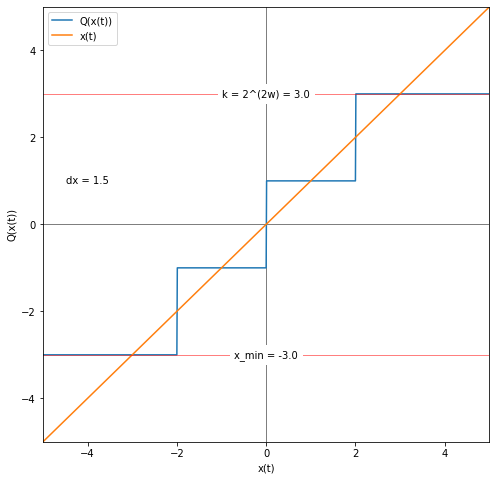

In [58]:

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlabel('x(t)')
ax.set_ylabel('Q(x(t))')


ax.axhline(0., linewidth=.5, color='k')
ax.axvline(0., linewidth=.5, color='k')

ax.plot(ramp, qs, label='Q(x(t))')
ax.plot(ramp, ramp, label='x(t)')

ax.axhline(x_min, linewidth=.5, color='r')
plt.text(0, x_min, f'x_min = {x_min}', fontsize=10, va='center', ha='center', backgroundcolor='w')

ax.axhline(x_max, linewidth=.5, color='r')
plt.text(0, x_max, f'x_max = {x_max}', fontsize=10, va='center', ha='center', backgroundcolor='w')

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)


plt.text(0, x_max, f'w = {x_max}', fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.text(0, x_max, f'k = 2^(2w) = {x_max}', fontsize=10, va='center', ha='center', backgroundcolor='w')


plt.text(-4, 1, f'dx = {dx}', fontsize=10, va='center', ha='center', backgroundcolor='w')

plt.legend()

### 4.2 Quantizing the fundamental frequency

x_range 320
x_center 240.0
Successfully loaded audio signal with 1 channel!


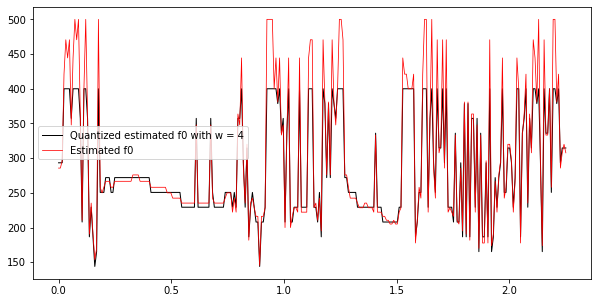

In [59]:
def quantize_f0(num_bits=4):
    f_min, f_max = 80, 400
    x_range = f_max - f_min
    x_center = f_min + (x_range / 2)

    print('x_range %s' %  x_range)
    print('x_center %s' %  x_center)

    # estimate f0
    f0 = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

    # quantize 
    qidx = quantize_encoder(f0, num_bits, x_range, x_center)
    q_f0 = quantize_decoder(qidx, num_bits, x_range, x_center)
    
    return q_f0, f0

w = 4
q_f0, f0 = quantize_f0(w)

plt.figure(figsize=(10,5))
t = np.linspace(0, female.duration_s, len(f0))
eff_plot_q = plt.plot(t, q_f0, color='k', linewidth=1., label='Quantized estimated f0 with w = %s' % w)
eff_plot = plt.plot(t, f0, color='r', linewidth=.75, label='Estimated f0')
plt.legend()


_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, q_f0)
output_sig.play()

x_range 320
x_center 240.0
x_range 320
x_center 240.0
x_range 320
x_center 240.0


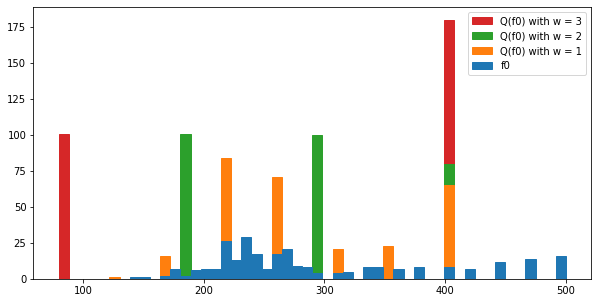

In [79]:
fig, ax = plt.subplots(1, figsize=(10, 5))


labels = ['f0'] + ['Q(f0) with w = %s' % w for w in [1, 2, 3]]

f0 = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

w = 1
q_f0_w1, _ = quantize_f0(w)
#ax.hist(q_f0, bins=500, color='b', label='quantized estimated f0 with w = %s' % w);

w = 2
q_f0_w2, _ = quantize_f0(w)

w = 3
q_f0_w3, _ = quantize_f0(w)

ax.hist(np.stack((f0, q_f0_w3, q_f0_w2, q_f0_w1)).T, 50, density=False, histtype='step', fill=True, label=labels);
ax.legend()

### 4.3 Quantizing the signal energy

In [63]:
def quantize_energy(num_bits, x_range, x_center, log=False):
    
    frame_centers_ms, frames = female.get_frames(8, 8)
    power = ut.compute_power_in_time_domain(frames)
    
    if log:
        power = np.log(power)
    
    qidx = quantize_encoder(power, num_bits, x_range, x_center)
    q_energy = quantize_decoder(qidx, num_bits, x_range, x_center)
    
    return q_energy

## Plot the histogram of the signal energy with num_bins=50. Find appropriate values for x_range and x_center based on the histogram.


(281,)
0.0013411995
0.0006705997511744499


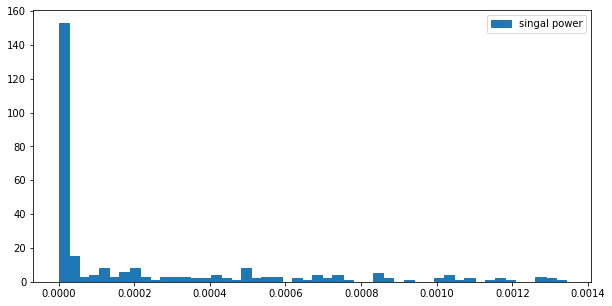

In [64]:
frame_centers_ms, frames = female.get_frames(8, 8)
power = ut.compute_power_in_time_domain(frames)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(power, 50, density=False, histtype='step', fill=True, label='singal power');
ax.legend()

print(power.shape)
x_range = max(power) - min(power)
print(x_range)
x_center = x_range / 2
print(x_center)


# Again, like for the fundamental frequency, find the minimum number of bits that is needed to avoid audible signal distortions

In [66]:
w = 10

frame_centers_ms, frames = female.get_frames(8, 8)
power = ut.compute_power_in_time_domain(frames)

x_range = max(power) - min(power)
x_center = min(power) + x_range / 2

q_e = quantize_energy(w, x_range, x_center)

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, q_e, f0)
output_sig.play()

Successfully loaded audio signal with 1 channel!


#### Now, take the logarithm of the energy values. Plot a histogram and find x_range as well as x_center.


13.795814
-13.512096881866455
-6.61419
-20.410004


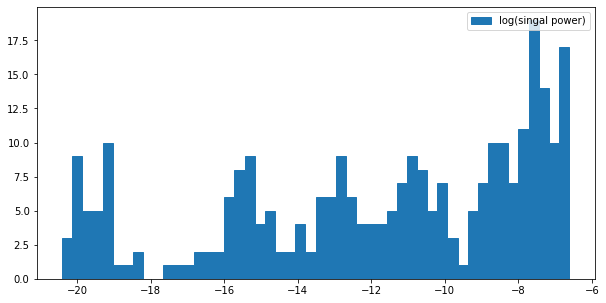

In [67]:
frame_centers_ms, frames = female.get_frames(8, 8)
power = ut.compute_power_in_time_domain(frames)
log_power = np.log(power)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(log_power, 50, density=False, histtype='step', fill=True, label='log(singal power)');
ax.legend()

x_range = max(log_power) - min(log_power)
print(x_range)
x_center = min(log_power) + x_range / 2
print(x_center)

print(max(log_power))
print(min(log_power))

##  How many bits do you need now? What is the reason for taking the logarithm?


In [68]:
w = 4

q_e = quantize_energy(w, x_range, x_center, log=True)

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, np.exp(q_e), f0)
output_sig.play()

Successfully loaded audio signal with 1 channel!


13.795814
-13.512096881866455
-6.61419
-20.410004


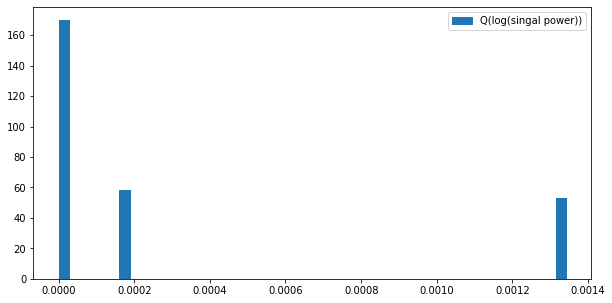

In [82]:
x_range = max(log_power) - min(log_power)
print(x_range)
x_center = min(log_power) + x_range / 2
print(x_center)

print(max(log_power))
print(min(log_power))

w = 3

q_e = quantize_energy(w, x_range, x_center, log=True)


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(np.exp(q_e), 50, density=False, histtype='step', fill=True, label='Q(log(singal power))');
ax.legend()

## 4.4 Quantizing the LPCs

### Compute the log area ratios LAR by first transforming the LPCs to reflection coefficients, using poly2rc. Then, obtain LAR from r either via the formula above or via rc2lar. On the receiver side, for obtaining the quantized LPCs, the inverse functions lar2rc and rc2poly can be used.

In [70]:
def quantize_lpc(num_bits, x_range, x_center):
    _, frames = female.get_frames(frame_length_ms=32, frame_shift_ms=8)
    lpcs = ut.compute_lpc(frames, m=10)
    LARs = np.array([ut.rc2lar(ut.poly2rc(np.concatenate(([1], lpc)))) for lpc in lpcs])
    
    qidx = quantize_encoder(LARs, num_bits, x_range, x_center)
    q_lars = quantize_decoder(qidx, num_bits, x_range, x_center)
    
    q_lpcs = np.array([ut.rc2poly(ut.lar2rc(lar)) for lar in q_lars])
    
    return q_lars, q_lpcs

(278, 10)
8.018892270704725
-0.513279128291046


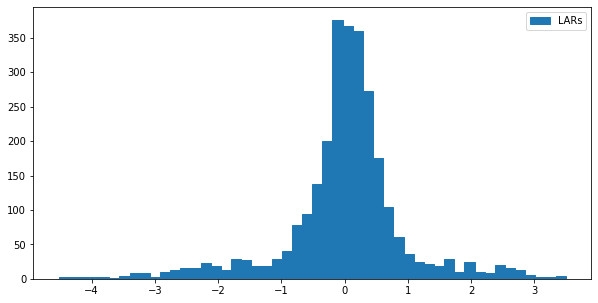

In [71]:
_, frames = female.get_frames(frame_length_ms=32, frame_shift_ms=8)
lpcs = ut.compute_lpc(frames, m=10)
LARs = np.array([ut.rc2lar(ut.poly2rc(np.concatenate(([1], lpc)))) for lpc in lpcs])

print(LARs.shape)

x_range = max(LARs.ravel()) - min(LARs.ravel())
print(x_range)

x_center = min(LARs.ravel()) + x_range / 2
print(x_center)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(LARs.ravel(), 50, density=False, histtype='step', fill=True, label='LARs');
ax.legend()

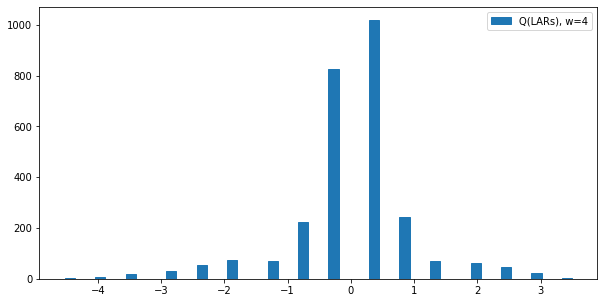

In [72]:
w = 4
q_lars, q_lpc = quantize_lpc(w, x_range, x_center)


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(q_lars.ravel(), 50, density=False, histtype='step', fill=True, label=f'Q(LARs), w={w}');
ax.legend()

In [106]:
w = 4

x_range = max(LARs.ravel()) - min(LARs.ravel())
x_center = min(LARs.ravel()) + x_range / 2

q_lars, q_lpc = quantize_lpc(w, x_range, x_center)

w = 4
x_range = max(log_power) - min(log_power)
x_center = min(log_power) + x_range / 2


q_e = quantize_energy(w, x_range, x_center, log=True)


w = 3
q_f0_w3, _ = quantize_f0(w)


frame_centers, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

print(len(ex_unvoiced_frames[1]))

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, np.exp(q_e), q_f0_w3, concat=True)
output_sig.play()

x_range 320
x_center 240.0
64
Successfully loaded audio signal with 1 channel!


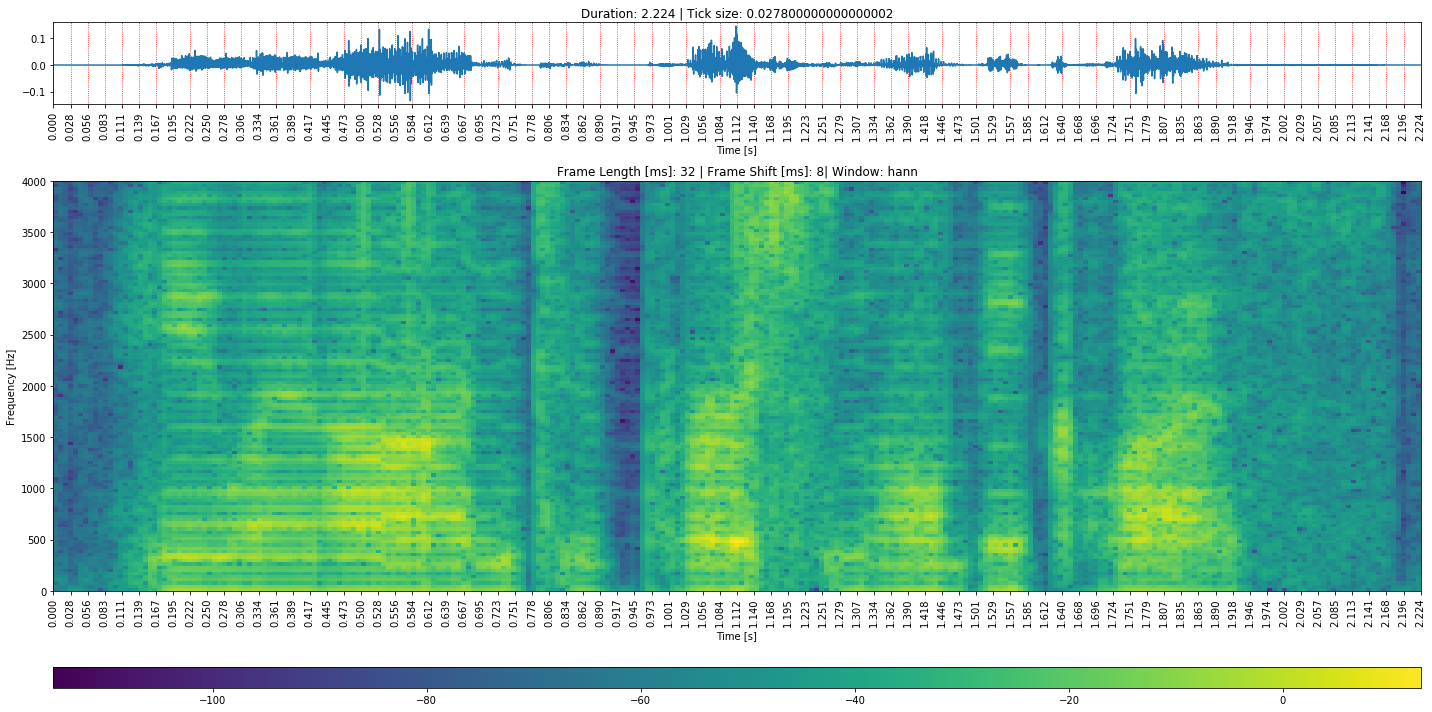

In [95]:
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

Successfully loaded audio signal with 1 channel!


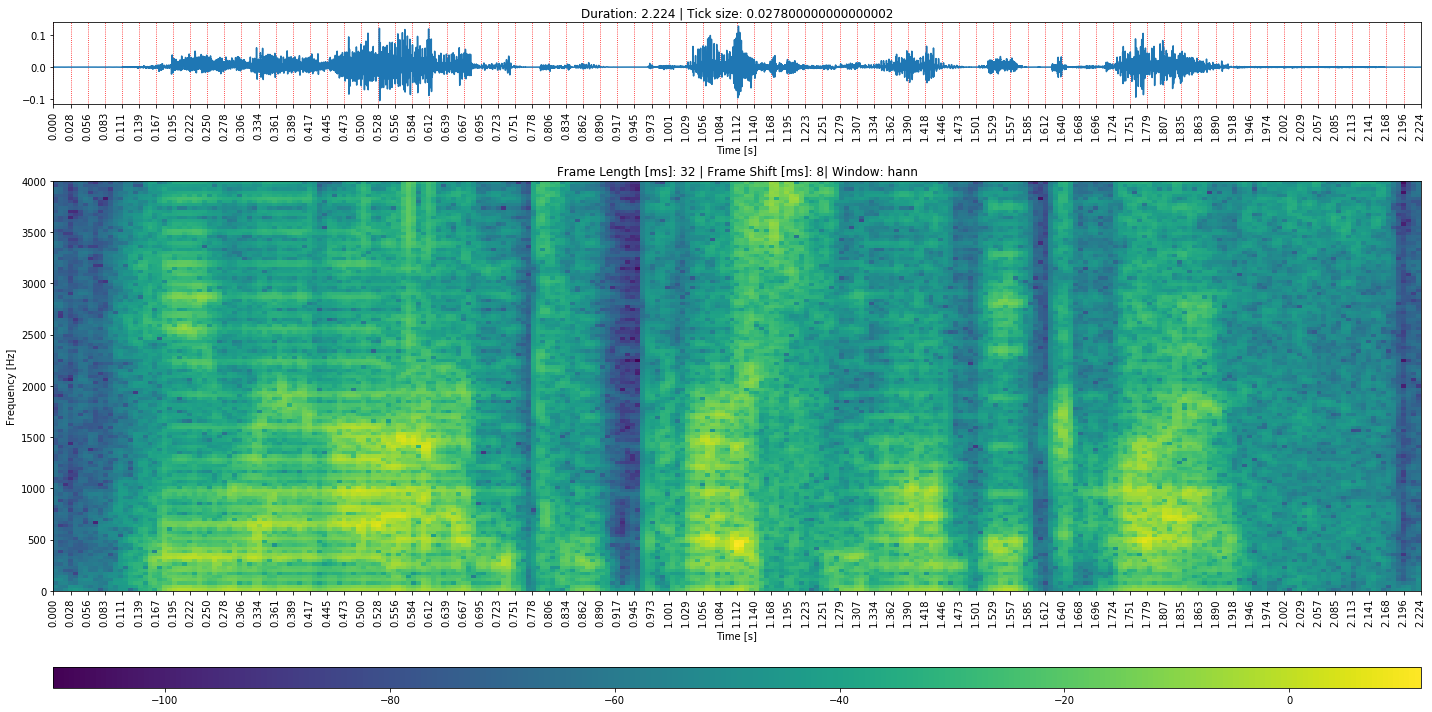

In [98]:
_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
output_sig = synthesize(ex_voiced_frames, ex_unvoiced_frames, q_lpc, is_voiced, np.exp(q_e), q_f0_w3, concat=False)
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 4.5 Data rate